# Setup

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

from datasets import load_dataset
import torch as t
from einops import rearrange, einsum
import matplotlib.pyplot as plt
from tqdm import tqdm

from nnsight import LanguageModel
from buffer import MultiModelActivationBuffer
from trainers.top_k import TopKTrainer, AutoEncoderTopK
from training import trainSAE
from dashboards import display_top_contexts_for_feature


device = "cuda:0"
dtype = t.bfloat16
t.set_grad_enabled(False)

In [2]:
layer = 4
out_batch_size = 4*4096

submodule_list = []
model_list = []
for step in [0, 128, 256, 512, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 143000]:
    model = LanguageModel(
        "EleutherAI/pythia-70m", 
        revision=f"step{step}", 
        trust_remote_code=False, 
        device_map=device,
        torch_dtype=dtype,
        )
    for x in model.parameters():
        x.requires_grad = False
    model_list.append(model)
    submodule_list.append(model.gpt_neox.layers[layer])
    
activation_dim = 512

dataset = load_dataset(
    'Skylion007/openwebtext', 
    split='train', 
    streaming=True,
    trust_remote_code=True
    )

dataset = dataset.shuffle(42)

class CustomData():
    def __init__(self, dataset):
        self.data = iter(dataset)

    def __iter__(self):
        return self

    def __next__(self):
        return next(self.data)['text']

In [4]:
def concat(x):
    return rearrange(x, 'b n d -> b (n d)')
def unconcat(x):
    return rearrange(x, 'b (n d) -> b n d', n=len(model_list))

In [65]:
ae = AutoEncoderTopK.from_hf("jacobcd52/pretraining_diffing", k=128, device=device)

/root/pretraining_diffing/notebooks/../trainers/top_k.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t.load(path)


In [6]:
# Get top acts and inds for making dashboards later
n_batches = 10

tokens = []
top_acts = []
top_inds = []

buffer = MultiModelActivationBuffer(
    data=CustomData(dataset),
    model_list=model_list,
    submodule_list=submodule_list,
    d_submodule=activation_dim, # output dimension of the model component
    n_ctxs=256,  # you can set this higher or lower dependong on your available memory
    device=device,
    refresh_batch_size=128,
    out_batch_size=out_batch_size,
    remove_bos=True
)

buffer.rescale_acts = True
buffer.act_mean = ae.act_mean.cpu()
buffer.act_cov_inv_sqrt = ae.act_cov_inv_sqrt.cpu()

for _ in tqdm(range(n_batches)):
    
    x, tokens_batch = buffer.get_seq_batch()
    _, top_acts_batch, top_inds_batch, _ = ae.encode(x, return_topk=True) 
    top_acts.append(top_acts_batch)
    top_inds.append(top_inds_batch)
    tokens.append(tokens_batch)

tokens = t.cat(tokens)
top_acts = t.cat(top_acts)
top_inds = t.cat(top_inds)
print(tokens.shape, top_acts.shape, top_inds.shape)

100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

torch.Size([1280, 127]) torch.Size([1280, 127, 128]) torch.Size([1280, 127, 128])


# Decoder projections

In [90]:
dec = rearrange(ae.decoder.weight, "(n_models d) d_hid -> d_hid n_models d", n_models=len(model_list))
power = dec.pow(2).sum(-1)

Wide: 75% of features are dataset features


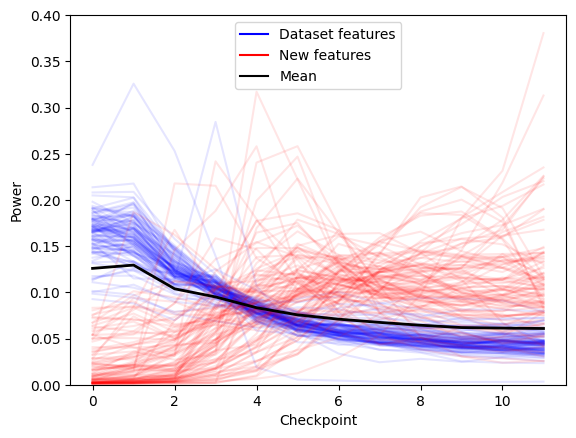

In [100]:
cpower = power.cumsum(-1)
is_dataset_feature = power[:, 0] > 1/12 # power.argmax(-1) < 2
dataset_power = power[is_dataset_feature]
new_power = power[~is_dataset_feature]

print(f"Wide: {is_dataset_feature.float().mean()*100:.0f}% of features are dataset features")
for i in range(100):
    plt.plot(dataset_power[i].detach().cpu(), color='blue', alpha=0.1)

for i in range(100):
    plt.plot(new_power[i].detach().cpu(), color='red', alpha=0.1)

mean = power.mean(0).detach().cpu()
plt.plot(mean, color='black', linewidth=2)

plt.ylim(0, 0.4)
plt.xlabel('Checkpoint')
plt.ylabel('Power')

# legend
plt.plot([], color='blue', label='Dataset features')
plt.plot([], color='red', label='New features')
plt.plot([], color='black', label='Mean')
plt.legend()


plt.show()

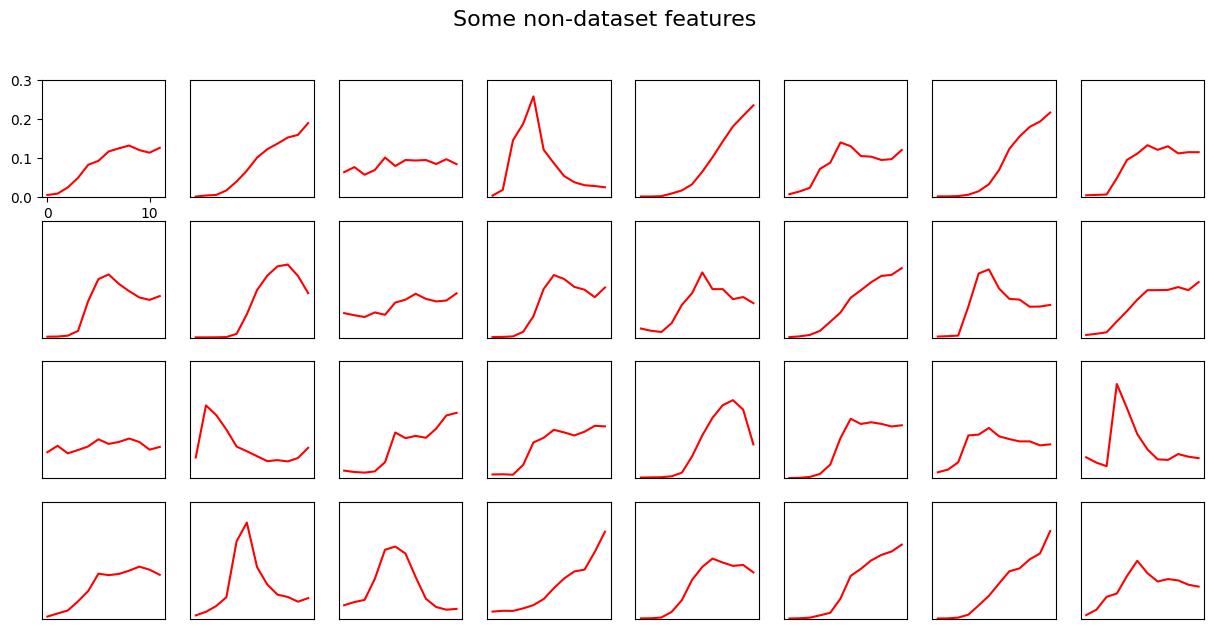

In [92]:
fig, axs = plt.subplots(4, 8, figsize=(15, 7))
for i in range(32):
    ax = axs[i//8, i%8]
    ax.plot((new_power[i]).detach().cpu(), color='red', alpha=1)
    ax.set_ylim(0, 0.3)
    if i > 0:
        ax.set_yticks([])
        ax.set_xticks([])

fig.suptitle('Some non-dataset features', fontsize=16)
plt.show()

(0.0, 0.3)

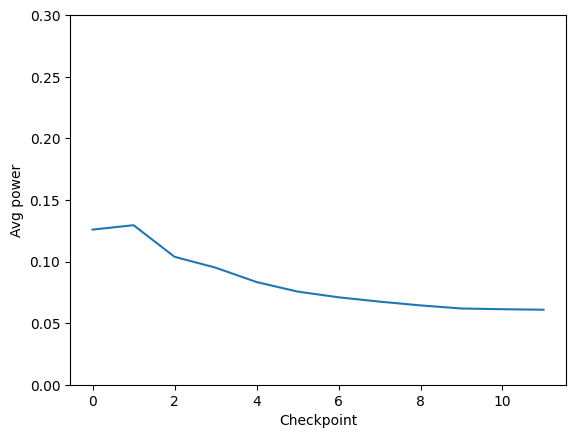

In [93]:
plt.plot(power.mean(0).detach().cpu())
plt.xlabel('Checkpoint')
plt.ylabel('Avg power')
plt.ylim(0, 0.3)

In [11]:
n_batches = 10
fvu = t.zeros(len(model_list)).cuda()

for _ in tqdm(range(n_batches)):
    x = next(buffer)
    x_hat = ae(x)

    x = unconcat(x)
    x_hat = unconcat(x_hat)
    
    fvu += (x - x_hat).var(0).sum(-1) / x.var(0).sum(-1)

fvu = fvu / n_batches

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


(0.0, 0.4)

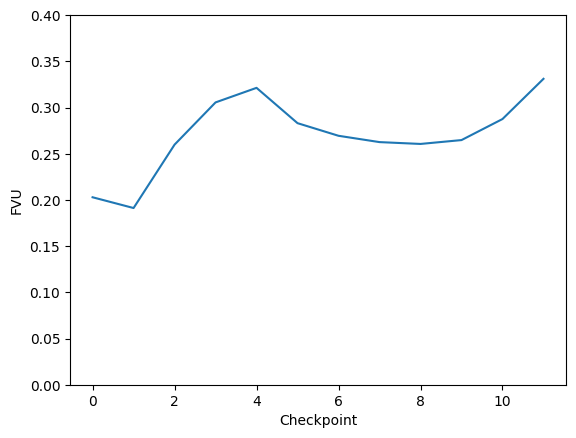

In [94]:
plt.plot(fvu.cpu())
plt.xlabel('Checkpoint')
plt.ylabel('FVU')
plt.ylim(0, 0.4)

In [107]:
del result
gc.collect()
t.cuda.empty_cache()    

# Avg_act * decoder power

In [108]:
batch, seq, k = top_inds.shape
N = dec.shape[0]
result = t.zeros(batch, seq, N, device=top_inds.device, dtype=top_acts.dtype)
result.scatter_(2, top_inds, top_acts)
avg_acts = result.mean([0,1]) # [n_features]

In [109]:
avg_acts

tensor([0.0085, 0.0169, 0.0120,  ..., 0.0087, 0.0136, 0.0076], device='cuda:0')

In [110]:
0.01 / 12

0.0008333333333333334

Wide: 75.10% of features are dataset features


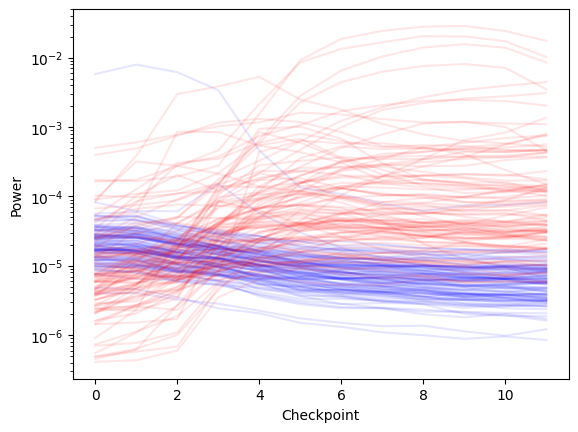

In [111]:
dec = rearrange(ae.decoder.weight.clone(), "(n_models d) d_hid -> d_hid n_models d", n_models=len(model_list))
dec *= avg_acts.unsqueeze(-1).unsqueeze(-1)
power = dec.pow(2).sum(-1)

cpower = power.cumsum(-1)
is_dataset_feature = power[:, 0] > power.mean(-1) # power.argmax(-1) < 2
dataset_power = power[is_dataset_feature]
new_power = power[~is_dataset_feature]

print(f"Wide: {is_dataset_feature.float().mean()*100:.2f}% of features are dataset features")
for i in range(min(100, len(dataset_power))):
    plt.plot(dataset_power[i].detach().cpu(), color='blue', alpha=0.1)

for i in range(min(100, len(new_power))):
    plt.plot(new_power[i].detach().cpu(), color='red', alpha=0.1)

# plt.ylim(0, 0.001)
plt.xlabel('Checkpoint')
plt.ylabel('Power')
# log scale
plt.yscale('log')

plt.show()

Text(0, 0.5, 'Avg power')

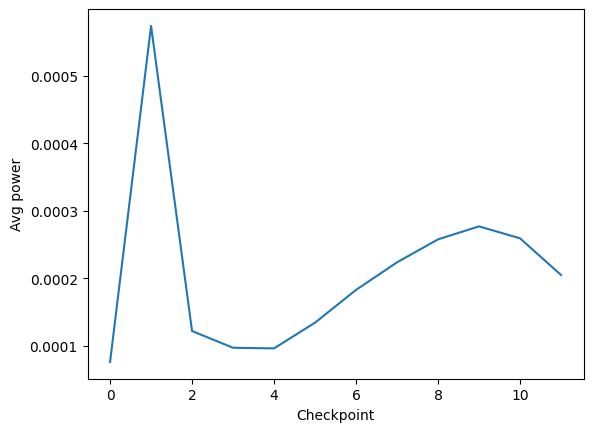

In [112]:
plt.plot(power.mean(0).detach().cpu())
plt.xlabel('Checkpoint')
plt.ylabel('Avg power')
# plt.ylim(0, 0.3)

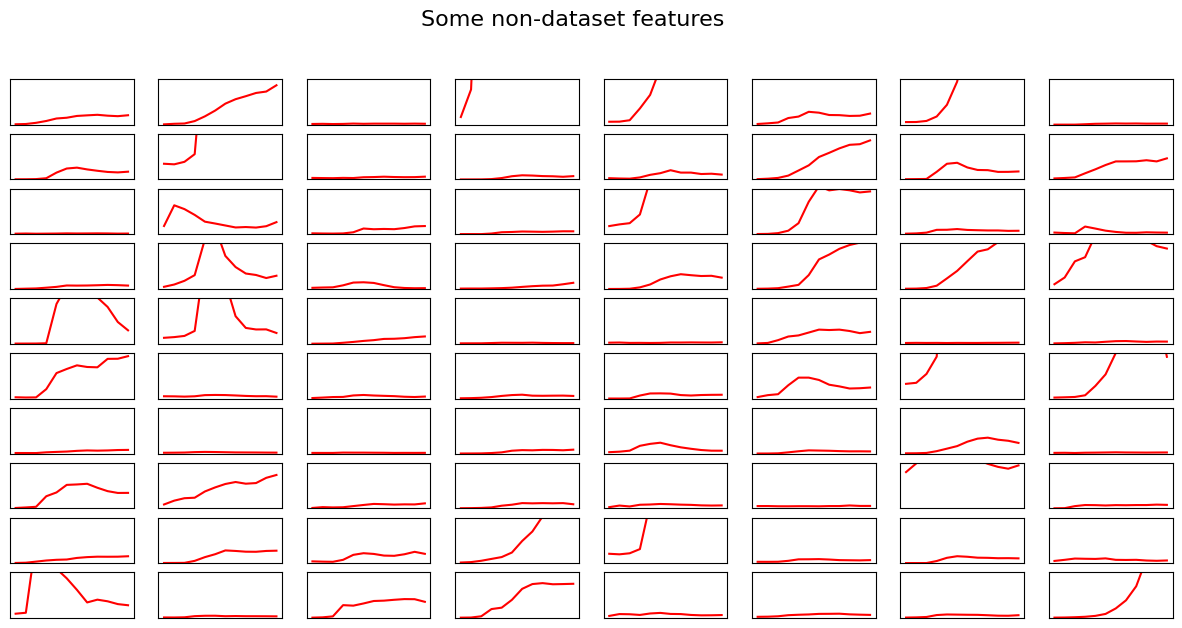

In [119]:
fig, axs = plt.subplots(10, 8, figsize=(15, 7))
for i in range(80):
    ax = axs[i//8, i%8]
    ax.plot((new_power[i]).detach().cpu(), color='red', alpha=1)
    ax.set_ylim(0, 0.0005)

    ax.set_yticks([])
    ax.set_xticks([])

fig.suptitle('Some non-dataset features', fontsize=16)
plt.show()

# Dashboards

In [49]:
appear = (power > 1/12).float().argmax(-1)

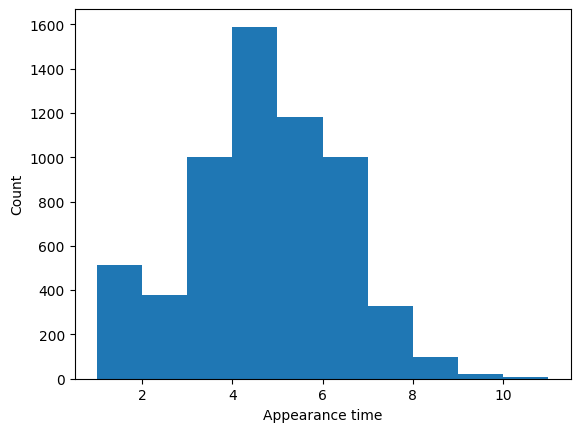

In [50]:
plt.hist(appear[~is_dataset_feature].cpu())
# make axes log
# plt.yscale('log')
# Set axis labels
plt.xlabel('Appearance time')
plt.ylabel('Count')
plt.show()


In [54]:
ex_feats = {}
for i in range(12):
    ex_feats[i] = t.where(appear == i)[0][:10]

In [66]:
for idx in ex_feats[10]:
    x = display_top_contexts_for_feature(
    model_list[0],
    tokens,
    top_acts,
    top_inds,
    feature_id=idx,
    left_context=20,
    right_context=3,
    minimal=True,
    num_to_show=8
    )
    display(x)

# Other definitions of appearance time

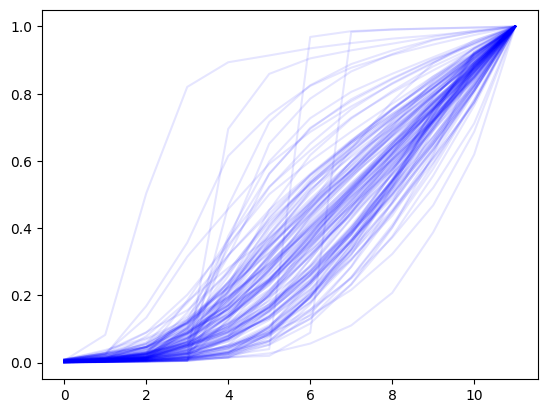

In [14]:
for i in range(1000):
    if power[i, 0] < 0.01:
        plt.plot(cpower.detach().cpu()[i], color='blue', alpha=0.1)

In [15]:
# For each feature, find first entry of cpower that exceeds 0.5
appear = (cpower > 0.2).float().argmax(-1)
appear.shape

torch.Size([24576])

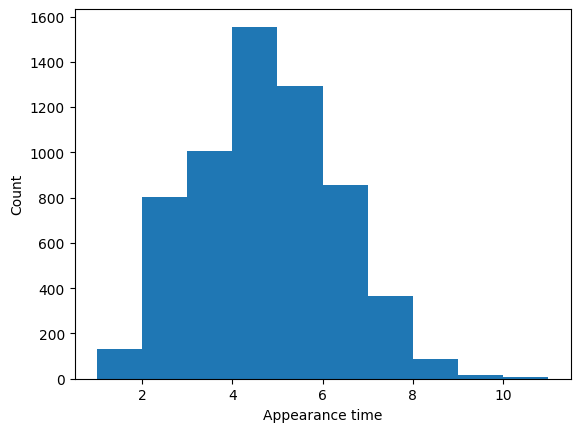

In [17]:
plt.hist(appear[~is_dataset_feature].cpu())
plt.xlabel('Appearance time')
plt.ylabel('Count')
plt.show()

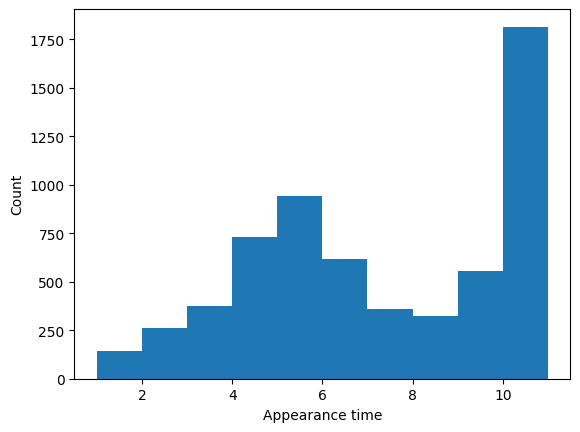

In [19]:
appear = power.argmax(-1)
plt.hist(appear[~is_dataset_feature].cpu())
plt.xlabel('Appearance time')
plt.ylabel('Count')
plt.show()

In [72]:
d = iter(dataset)

In [131]:
next(d)['text'][:30]

'hidden\n\nDelhi government has d'